# Credit Card Fraud Detection

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

In [43]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import sklearn.cross_validation as cross_val
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report 

Let's download the CSV and plug it into a dataset

In [2]:
cc_fraud_df = pd.read_csv(r'C:\Users\john.osorio\Desktop\BLACK CAT\Capstone Project\creditcardfraud\creditcard.csv')

A quick peek of the dataset will show us the following

In [3]:
cc_fraud_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.# Explain the dataset here a little bit about what the features represent

In [4]:
print('There were', '\033[1m',cc_fraud_df.shape[0],'\033[0m' , 'transactions in total')

fraud_transactions = cc_fraud_df[cc_fraud_df.Class == 1].Class.count()
# Show all the fraudulent transactions
print('There were', '\033[1m', fraud_transactions, '\033[0m' ,'fraudulent transactions')

legitimate_transactions = cc_fraud_df[cc_fraud_df.Class == 0].Class.count()
# Show all the legitimate transactions
print('There were', '\033[1m', legitimate_transactions, '\033[0m', ' legitimate transactions')

There were  284807  transactions in total
There were  492  fraudulent transactions
There were  284315   legitimate transactions


A barplot of the above numbers will show the disparity more obviously

[Text(0,0.5,'Number Of Transactions'), Text(0.5,0,'Legitimate (0) Fraud (1)')]

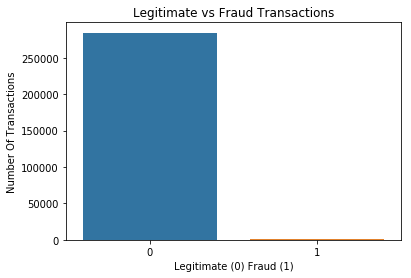

In [5]:
g = sns.barplot(x=[0, 1], y=[284315, 492])
g.set_title('Legitimate vs Fraud Transactions')
g.set(xlabel = 'Legitimate (0) Fraud (1)', ylabel = 'Number Of Transactions')

Since there is such an imbalance with the classes, we will need to resample it but more on that later

# Data Science Approach
1. Normalise the 'Time' and 'Amount' feature so that it is consistent with the other features
2. Resample the dataset so we get an even amount of classes
3. Then compare the resampled data against the original one by means of a simple Logistic Regression model
4. Finally we will evaluate the model using a Confusion Matrix and plot an ROC curve

# 1. Normalise the 'Time' and 'Amount' feature

In [6]:
cc_fraud_df['time_norm'] = StandardScaler().fit_transform(cc_fraud_df['Time'].values.reshape(-1, 1))
cc_fraud_df['amount_norm'] = StandardScaler().fit_transform(cc_fraud_df['Amount'].values.reshape(-1, 1))

# Then drop the original Time and Amount features
cc_fraud_df = cc_fraud_df.drop(['Time', 'Amount'], axis='columns')

Our updated dataset will now look like

In [7]:
cc_fraud_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,time_norm,amount_norm
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-1.996583,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-1.996583,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,-1.996562,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-1.996562,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-1.996541,-0.073403


# 2. Resample the dataset for an even amount of classes

Separate the X and y feature and target variables

In [8]:
X = cc_fraud_df.drop('Class', axis='columns')
y = cc_fraud_df.loc[:, cc_fraud_df.columns == 'Class']

Generate the same amount of Class 1 samples as with Class 0

In [9]:
# Get the total amount of fraud transactions and their index values
fraud_transactions = cc_fraud_df[cc_fraud_df.Class == 1].Class.count()
fraud_indices = np.array(cc_fraud_df[cc_fraud_df.Class == 1].index)

# Get the index values of the legitimate transactions
legitimate_indices = np.array(cc_fraud_df[cc_fraud_df.Class == 0].index)

# Get a random sample of legitimate transactions with size equal to the fraud transactions
random_legit = np.random.choice(legitimate_indices, size = fraud_transactions, replace=False)
random_legit = np.array(random_legit)

# Now combine the fraud and legitimate indices
under_sample_index_array = np.concatenate([random_legit, fraud_indices])

# Create an new dataframe for the under sampled data
under_sample_df = cc_fraud_df.iloc[under_sample_index_array, :]

print(under_sample_df.shape[0])

984


Now we have an even split of Class data

Separate the features and target for the under sampled dataframe

In [10]:
X_under_sample = under_sample_df.drop('Class', axis='columns')
y_under_sample = under_sample_df.loc[:, under_sample_df.columns == 'Class']

Split the data into training and test sets for both original and under sampled datasets

In [11]:
#Original Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

#Under sampled dataset
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_under_sample, y_under_sample, random_state = 42, test_size = 0.3)

# 3. Apply Logistic Regression to both datasets

Create a function that prints KFold Cross Validation scores to determine which c parameter to use

In [57]:
def print_kfold_scores(X_train_data, y_train_data):
    k_fold = KFold(n_splits = 5)
    #fold = KFold(y_train_data.shape[0], 5, shuffle=False) 

    # Let's try the following c parameters
    c_param_range = [0.01, 0.1, 1, 10, 100]
    
    results_df = pd.DataFrame(index = range(len(c_param_range),2), columns = ['c_parameter','mean_recall_score'])
    results_df['c_parameter'] = c_param_range

    index = 0
    for c_param in c_param_range:
        print('*******************************************')
        print('c parameter: ', c_param)
        print('*******************************************')
        print('')

        recall_accs = []
        iteration = 1
        for train_index, test_index in k_fold.split(X_train_data):
            # KFold will have two lists, indices[0] and indices[1]

            # Initialise a Logistic Regression model with a c parameter and use Lasso regularisation
            logreg = LogisticRegression(C = c_param, penalty = 'l1')

            # Use a portion of the KFold to train our model
            logreg.fit(X_train_data.iloc[train_index, :], y_train_data.iloc[train_index, :].values.ravel())

            # Predict values using the test indices in the training data
            y_pred_undersample = logreg.predict(X_train_data.iloc[test_index,:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[test_index,:].values, y_pred_undersample)
            recall_accs.append(recall_acc)
            print(iteration, ': recall score = ', recall_acc)
            iteration += 1
        
        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_df.loc[index, 'mean_recall_score'] = np.mean(recall_accs)
        index += 1
        print('')
        print('mean recall score ', np.mean(recall_accs))
        print('')

    best_c = results_df[results_df.mean_recall_score == results_df['mean_recall_score'].max()].c_parameter[0]
    
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [58]:
print_kfold_scores(X_train_u, y_train_u)

*******************************************
c parameter:  0.01
*******************************************

1 : recall score =  0.9545454545454546
2 : recall score =  0.9830508474576272
3 : recall score =  0.961038961038961
4 : recall score =  0.9759036144578314
5 : recall score =  0.9672131147540983

mean recall score  0.9683503984507945

*******************************************
c parameter:  0.1
*******************************************

1 : recall score =  0.9696969696969697
2 : recall score =  0.9152542372881356
3 : recall score =  0.8181818181818182
4 : recall score =  0.9397590361445783
5 : recall score =  0.9016393442622951

mean recall score  0.9089062811147594

*******************************************
c parameter:  1
*******************************************

1 : recall score =  0.9545454545454546
2 : recall score =  0.9152542372881356
3 : recall score =  0.8441558441558441
4 : recall score =  0.9397590361445783
5 : recall score =  0.9016393442622951

mean recall sco

0.01

Now we know that the best c parameter to use in this case is 0.01 so let's build the proper Logistic Regression model

In [14]:
logreg = LogisticRegression(C = 0.01, penalty='l1')
logreg.fit(X_train_u, y_train_u.values.ravel())

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Get our predictions

In [15]:
y_pred_undersample = logreg.predict(X_test_u.values)

Now compute the Confusion Matrix

In [16]:
cnf_mtx = confusion_matrix(y_test_u, y_pred_undersample)

In [17]:
print("Recall metric in the test dataset: ", cnf_mtx[1,1]/(cnf_mtx[1,0]+cnf_mtx[1,1]))

Recall metric in the test dataset:  0.910958904109589


In [18]:
# Create a function that plots a confusion matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (7,5), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    return fig

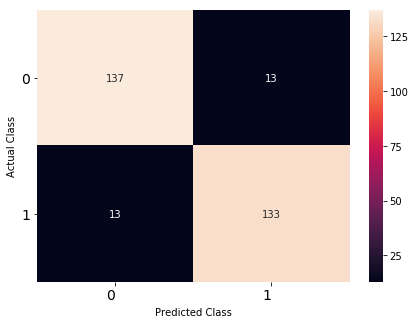

In [19]:
conf_matrix = print_confusion_matrix(cnf_mtx, class_names = [0, 1])

The model is offering a 91.1% recall accuracy on the generalised unseen data (test set), but this was for the under sampled dataset. Now let's try it on the original dataset

In [20]:
y_pred = logreg.predict(X_test.values)

In [21]:
cnf_mtx = confusion_matrix(y_test, y_pred)

In [22]:
print("Recall metric in the test dataset: ", cnf_mtx[1,1]/(cnf_mtx[1,0]+cnf_mtx[1,1]))

Recall metric in the test dataset:  0.9485294117647058


So now the result is not bad at 94.85% recall for the original test dataset

Finally, let's plot the ROC curve

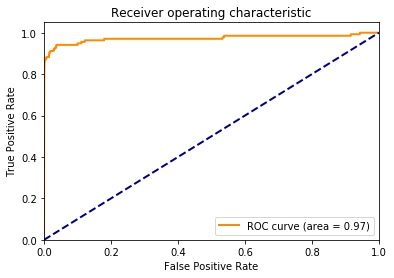

<Figure size 504x360 with 0 Axes>

In [26]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.figure(figsize=(7, 5))
plt.show()